In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('./Singapore.csv')

In [4]:
df.head()

,Unnamed: 0,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Population,Susceptiple,Log susceptiple,Decresed susceptiple
0,1,2020-01-23,1,0,0,1,1,0,0,5840996,5840995,15.580412,0
1,2,2020-01-24,3,0,0,3,2,0,0,5840996,5840993,15.580411,2
2,3,2020-01-25,3,0,0,3,0,0,0,5840996,5840993,15.580411,0
3,4,2020-01-26,4,0,0,4,1,0,0,5840996,5840992,15.580411,1
4,5,2020-01-27,5,0,0,5,1,0,0,5840996,5840991,15.580411,1


In [12]:
# The SIR model differential equations.
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [13]:
# Number of days
n_days = len(df)
# Total population, N.
N = df['Population'][0]
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = (df['Active'][0])/N, (df['Deaths'][0] + df['Recovered'][0])/N
# Everyone else, S0, is susceptible to infection initially.
S0 = 1 - I0 - R0
# A grid of time points (in days)
t = [i for i in range(n_days)]

In [14]:
ydata = df['Active']/N
sdata = df['Susceptiple']/N
# Initial conditions vector
y0 = S0, I0, R0
print(y0)

(0.9999998287963218, 1.7120367827678705e-07, 0.0, 0.0)


In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

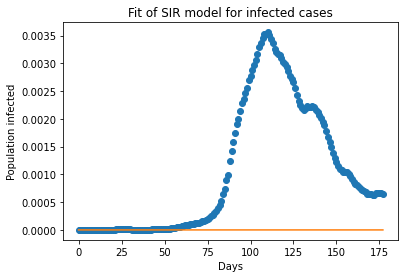

Optimal parameters: beta = 1.0  and gamma =  1.0  and theta =  1.0


In [19]:
def fit_odeint(t, beta, gamma):
    return integrate.odeint(deriv, y0, t, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
I = fit_odeint(t, *popt)
beta, gamma = popt[0], popt[1]

plt.plot(t, ydata, 'o')
plt.plot(t, I)
plt.title("Fit of SIR model for infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


In [30]:
# Integrate the SIR equations over the time grid, t.
# t = [i for i in range(1000)]
ret = integrate.odeint(deriv, y0, t, args=(2.5, 1, 1))
S, I, R, D = ret.T

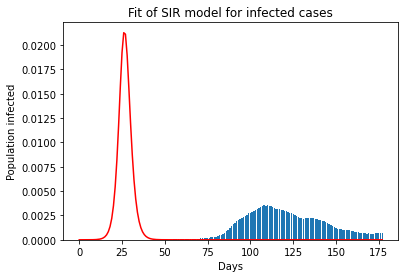

In [31]:
plt.bar(t, ydata)
plt.plot(t, I, 'r')
plt.title("Fit of SIR model for infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

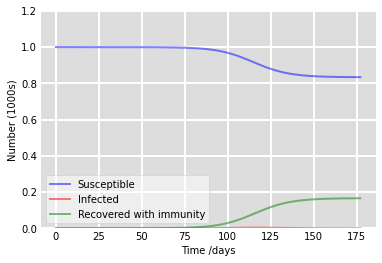

In [23]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [12]:
beta = np.random.rand()
gamma = np.random.rand()
print(beta, gamma)

0.711373308762959 0.08057057993641203


In [24]:
# Integrate the SIR equations over the time grid, t.
# t = [i for i in range(1000)]
ret = integrate.odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T

In [25]:
mean_y = np.mean(ydata)
denominator = np.sum((ydata - mean_y)**2)

In [26]:
class SIR_RNN_model(object):
    def __init__(self, S0, I0, R0, beta, gamma):
        self.S0, self.I0, self.R0 = S0, I0, R0
        self.beta, self.gamma = beta, gamma
        
    def loss(self, data, days, mode='train'):
        loss = 0
        grads = {'beta': 0, 'gamma': 0}
        
        S, I, R = self.sample(days)
        for day in range(1, days+1):
            loss += (I[day] - data[day])**2
        
        if mode == 'test':
            return loss
            
        dout_i = dout_s = 0       
        
        for day in range(days, 0, -1):  
            dout = 2 * (I[day] - data[day]) + dout_i + dout_s
                       
            grads['beta'] += dout * I[day-1] * S[day-1] + dout_s * (-S[day-1] * I[day-1])
            grads['gamma'] += dout * -I[day-1]
            
            dout_i = dout * (1 + beta * S[day-1] -gamma) + dout_s * (-beta * S[day-1])
            dout_s = dout * (beta * I[day-1]) + dout_s * (1 - beta * S[day-1])
            
        return loss, grads
    
    def fit(self, data, days, lr=0.01, epochs=100, momentum=0.9):
        v_beta = 0
        v_gamma = 0
        for i in range(epochs):
            loss, grads = self.loss(data, days)
            if loss < 1e-6:
                break
            if i % 1000 == 0:
                print('Epoch[{}/{}]--loss: {}'.format(i, epochs, loss))
            v_beta = momentum * v_beta + lr * grads['beta']
            v_gamma = momentum * v_gamma + lr * grads['gamma']
            self.beta -= v_beta
            self.gamma -= v_gamma
    
    def sample(self, days):
        S, I, R = [self.S0], [self.I0], [self.R0]
        beta, gamma = self.beta, self.gamma
        
        for day in range(1, days+1):
            S_new = S[day-1] - beta * S[day-1] * I[day-1]
            I_new = I[day-1] + beta * S[day-1] * I[day-1] - gamma * I[day-1]
            R_new = R[day-1] + gamma * I[day-1]
            
            S.append(S_new)
            R.append(R_new)
            I.append(I_new)
        
        return S, I, R

In [27]:
model = SIR_RNN_model(S0, I0, R0, beta, gamma)

In [37]:
S, I, R = model.sample(n_days-1)
loss, grads = model.loss(ydata, n_days-1)

In [38]:
print(loss, grads)

0.00038043071662596464 {'beta': -4.275483185626322e-06, 'gamma': -4.221475612413059e-06}


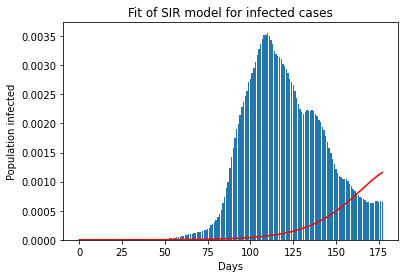

In [39]:
plt.bar(t, ydata)
plt.plot(t, I, 'r')
plt.title("Fit of SIR model for infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [33]:
lr = 0.01
epochs = 10000
momentum = 0
v_beta = 0
v_gamma = 0

In [41]:
model.fit(ydata, n_days-1, lr=lr, epochs=epochs, momentum=momentum)

Epoch[0/10000]--loss: 0.0003804084828157449
Epoch[1000/10000]--loss: 0.00038040625577487287
Epoch[2000/10000]--loss: 0.0003804040280671629
Epoch[3000/10000]--loss: 0.0003804017996922599
Epoch[4000/10000]--loss: 0.00038039957064980856
Epoch[5000/10000]--loss: 0.0003803973409394612
Epoch[6000/10000]--loss: 0.00038039511056085583
Epoch[7000/10000]--loss: 0.00038039287951364536
Epoch[8000/10000]--loss: 0.0003803906477974685
Epoch[9000/10000]--loss: 0.0003803884154119775


In [221]:
for i in range(epochs):
    ret = integrate.odeint(deriv, y0, t, args=(beta, gamma))
    S, I, R = ret.T
    loss, grads = loss_grad(I, ydata, sdata)
    
#     v_beta = momentum * v_beta + lr * grads['beta']
#     #v_gamma = momentum * v_gamma + lr * grads['gamma']
    gamma -= lr * grads['gamma']
    if i % 1000 == 0:
        print(loss, beta, gamma)

TypeError: cannot unpack non-iterable numpy.float64 object

In [222]:
print(loss)
print(beta, gamma)

4.2213342632562045e-07
0.9525153622744358 0.5710678039069049


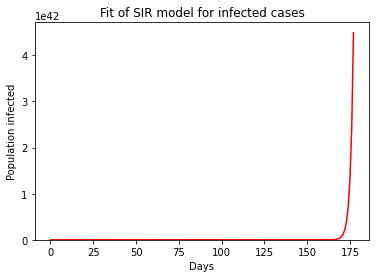

In [378]:
plt.bar(t, ydata)
plt.plot(t, I, 'r')
plt.title("Fit of SIR model for infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()